In [165]:
import pandas as pd

# load labels and data 
labels_df = pd.read_csv('data/labels.csv')
data = pd.read_parquet('data/data.parquet', engine='fastparquet')

The number of PumpFailed labels is 27385.
There is 23958 False labels (NORMAL condition of the pump) and 2942 True labels (BROKEN condition). 485 values do not have label which is 1.771042541537338% of all lables.


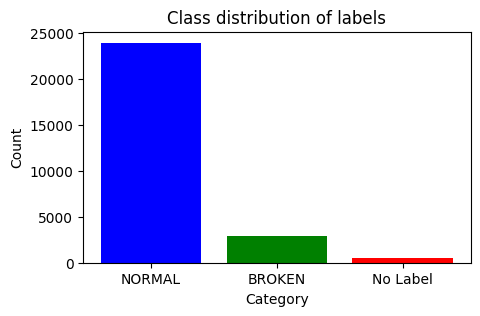

In [166]:
import numpy as np 
import matplotlib.pyplot as plt

# Labels distibution 
pump_failed_labels = labels_df['PumpFailed'].to_numpy()
nan_mask = np.array([item is np.nan for item in pump_failed_labels])
# count missing labels 
count_nans = np.sum(nan_mask)
filtered_pump_failed = pump_failed_labels[~nan_mask]
filtered_pump_failed = filtered_pump_failed.astype(bool)
count_true = np.count_nonzero(filtered_pump_failed)
count_false = np.sum(~filtered_pump_failed)
print(f"The number of PumpFailed labels is {len(pump_failed_labels)}.")
print(f"There is {count_false} False labels (NORMAL condition of the pump) and {count_true} True labels (BROKEN condition). {count_nans} values do not have label which is {(count_nans/len(pump_failed_labels)) * 100}% of all lables.")

# plot chart
label_names = ['NORMAL', 'BROKEN', 'No Label']
counts = [count_false, count_true, count_nans]
plt.figure(figsize=(5, 3))  
plt.bar(label_names, counts, color=['blue', 'green', 'red'])  
plt.title('Class distribution of labels')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(label_names)
plt.show()

# By looking at the distribution of labels, I decided to remove the data that do not have label. Another idea of how to solve
# the missing labels problem was to use another two labels available in the dataset - SlowStart and SlowEnd. By using SlowStart and SlowEnd as features, we could predict
# the missing values of PumpFailed vector. 
# However, I decided not to take this approach, since the number of the missing labels is negligible (less than 2% of all PumpFailed labels).

In [167]:
# Further on, I decided to check if there are any missing values in the pressure parameter. 
pressure = data['Pressure'].to_numpy()
count_nans_pressure = np.sum(np.array([item is np.nan for item in pressure]))
print(f"There is {count_nans_pressure} missing values in pressure parameter.")

There is 0 missing values in pressure parameter.


In [168]:
# Data cleaning 

# filter out missing values in labels
filtered_labels = labels_df.dropna(subset=['PumpFailed'])
nan_labels = labels_df[labels_df['PumpFailed'].isna()][['MachineId', 'MeasurementId']]
# subset of data that do not have labels in labels dataframe
nan_merged = data.merge(nan_labels, on=['MachineId', 'MeasurementId'], how='left', indicator=True)
# filter original dataset by removing all rows that do not have label
filtered_data = nan_merged[nan_merged['_merge'] == 'left_only'].drop(columns=['_merge'])
# check for duplicate rows in the dataset
duplicates = filtered_data.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate values is {num_duplicates}..")

# Typically, during the data cleaning process, one important step involves eliminating duplicate values to improve overall model performance. 
# However, in my initial attempt to remove duplicate values, I observed that there were numerous duplicate rows in the dataset because the same value had been measured multiple times at different time slots. 
# Since the timestamp information was missing I decided against deleting these duplicate rows because they actually hold value for our model (we do now that the measured data were ordered by time, and the time intervals between individual observations are always the same.)

Number of duplicate values is 9488653..


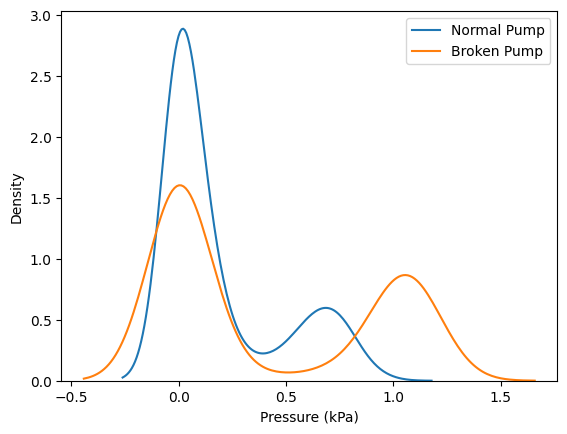

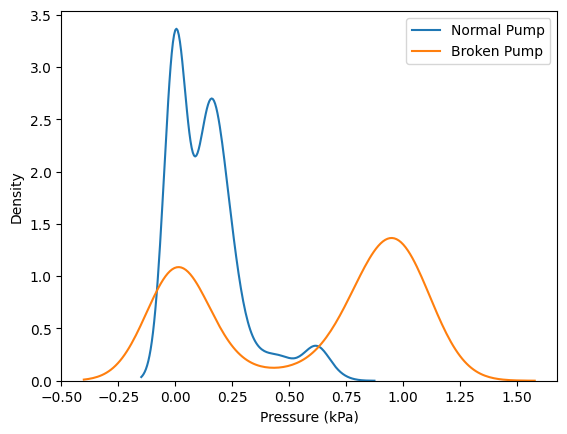

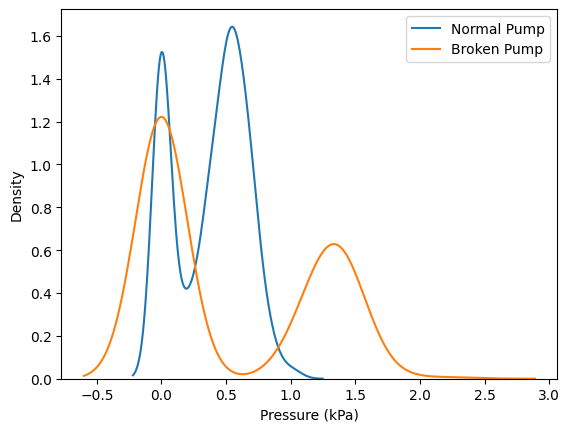

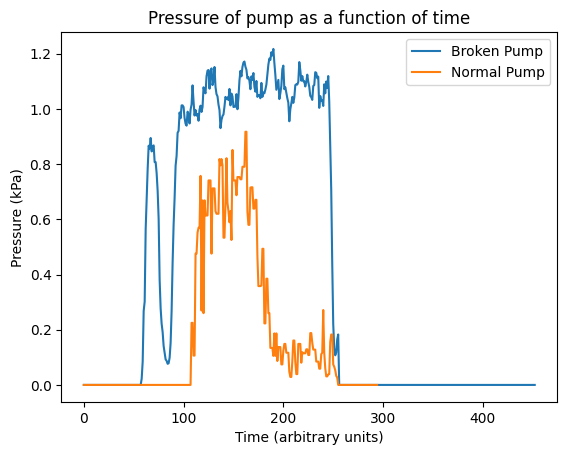

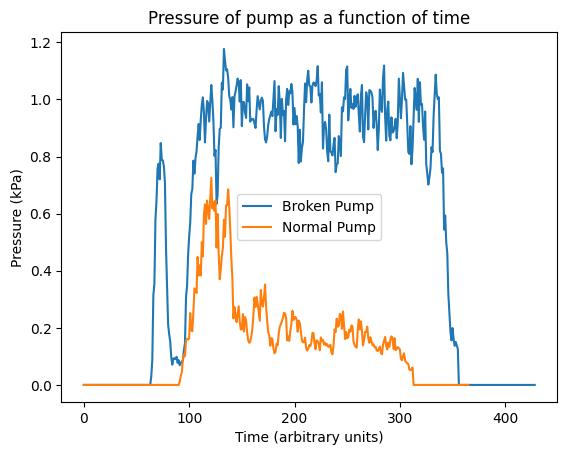

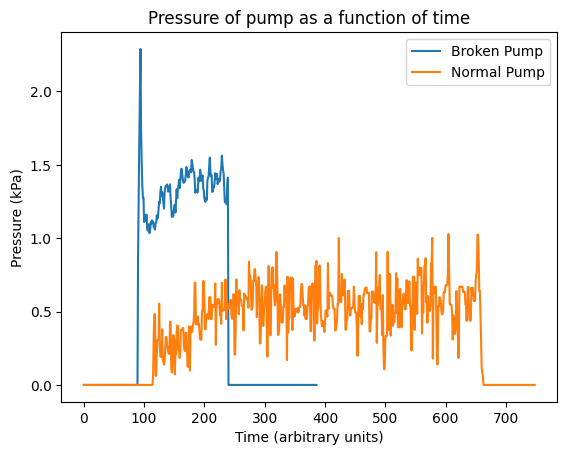

In [182]:
#  EDA 
import seaborn as sns

def plot_pump_data(full_data: pd.DataFrame, ids_failed: list, ids_did_not_fail: list, plot_type: str) -> None:
    """
    Plots pressure data (either KDE of pressure or pressure over time) for pumps that failed and did not fail.
    """
    for i in range(len(ids_failed)):
        pumps_failed = full_data[(full_data['MachineId'] == ids_failed[i][0]) & 
                                 (full_data['MeasurementId'] == ids_failed[i][1])]
        pumps_not_failed = full_data[(full_data['MachineId'] == ids_did_not_fail[i][0]) & 
                                     (full_data['MeasurementId'] == ids_did_not_fail[i][1])]

        if plot_type == 'kde':
            sns.kdeplot(pumps_not_failed['Pressure'], label='Normal Pump')
            sns.kdeplot(pumps_failed['Pressure'], label='Broken Pump')
            plt.xlabel('Pressure (kPa)')
            plt.ylabel('Density')
        elif plot_type == 'time':
            time_axis_failed = range(len(pumps_failed))
            time_axis_not_failed = range(len(pumps_not_failed))
            plt.plot(time_axis_failed, pumps_failed['Pressure'], label='Broken Pump')
            plt.plot(time_axis_not_failed, pumps_not_failed['Pressure'], label='Normal Pump')
            plt.title('Pressure of pump as a function of time')
            plt.xlabel('Time (arbitrary units)')
            plt.ylabel('Pressure (kPa)')
            
        plt.legend()
        plt.show()

# merge data with labels into one dataframe 
full_data = pd.merge(filtered_data, filtered_labels, on=['MachineId', 'MeasurementId'])
full_data['PumpFailed'] = full_data['PumpFailed'].astype(bool)

# split the data of the pumps that failed and the ones that did not fail
failed_pumps = full_data[full_data['PumpFailed']]
non_failed_pumps = full_data[~full_data['PumpFailed']]

# plot distribution of data for failed and non-failed pump, for 3 randomly chosen cycles
# plot is done over pairs because of clearness and better visualization, pairs are randomly chosen 
ids_failed = [('6_0_1',30), ('7_2_1',83), ('4_0_1', 97)]
ids_did_not_fail = [('0_0_2',8),('1_2_3',12),('9_0_2',119)]
plot_pump_data(full_data, ids_failed, ids_did_not_fail, plot_type='kde')
plot_pump_data(full_data, ids_failed, ids_did_not_fail, plot_type='time')


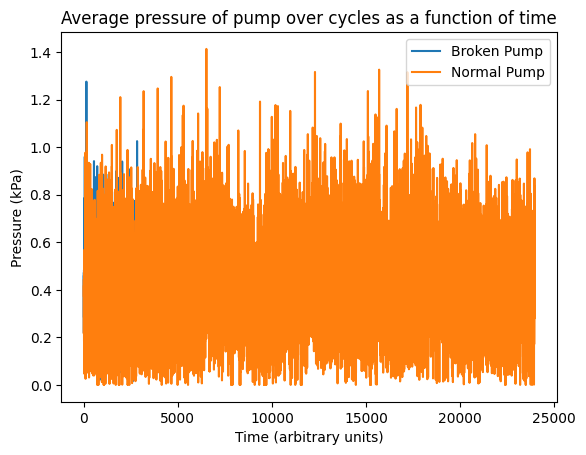

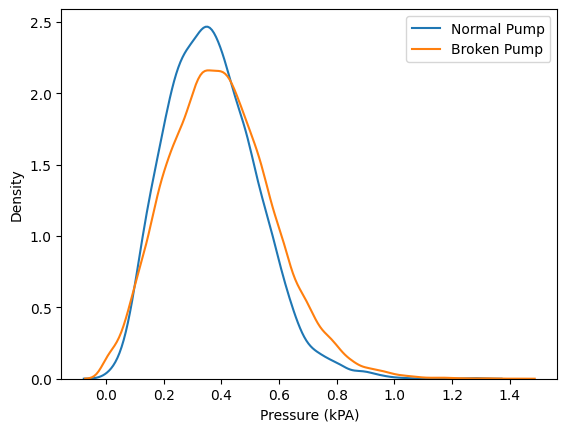

In [119]:
# Since random selection of cycles may not guarantee representativeness of the data, particularly in the case of a large dataset like ours, 
# I decided to plot average values calculated over entire cycles. 

avg_pressure_failed = failed_pumps.groupby(['MeasurementId', 'MachineId'])['Pressure'].mean().reset_index()
avg_pressure_not_failed = non_failed_pumps.groupby(['MeasurementId', 'MachineId'])['Pressure'].mean().reset_index()
time_avg_axis_failed = range(len(avg_pressure_failed))
time_avg_axis_not_failed = range(len(avg_pressure_not_failed))

# average pressure over time plot
plt.plot(time_avg_axis_failed, avg_pressure_failed['Pressure'], label='Broken Pump')
plt.plot(time_avg_axis_not_failed, avg_pressure_not_failed['Pressure'], label='Normal Pump')
plt.title('Average pressure of pump over cycles as a function of time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Pressure (kPa)')
plt.legend()
plt.show()

# average kde plots 
sns.kdeplot(avg_pressure_failed['Pressure'], label='Normal Pump')
sns.kdeplot(avg_pressure_not_failed['Pressure'], label='Broken Pump')
plt.xlabel('Pressure (kPA)')
plt.ylabel('Density')
plt.legend()

# This approach did not give me more informative insights compared to the previous method. 
# From the KDE plot generated earlier, we can observe notable differences in the distribution of data when the pump has failed versus when it is functioning normally. 
# In cases where the pump failure occurred, we observe lower peak values in the second half of the cycle, as well as a differences in standard deviation from the mean during the second half of the cycle.
# Additionally, there is a noticeable contrast in skewness between the data when the pump is in normal vs. when it is malfunctioning. 

In [170]:
# Feature engineering 

# Based on the insights gained from the exploratory data analysis (EDA), 
# I proceeded with creating features that could effectively differentiate between the normal and malfunctioning states of the pump.
# To ensure that the overal information from each cycle is perserved, I chose to begin with the average value calculated over each complete cycle as the first feature.
# Further on, I decided to use the fact that the standard deviation from the mean differs in NORMAL vs. BROKEN pump in second half of the 
# cycle, as well as the spike (maximum value) in the same time interval. Fourth feature that I added was skewness, in order to 
#  capture the asymmetry of the data distribution.

# 1. Average pressure feature 
avg_pressure_df = full_data.groupby(['MeasurementId', 'MachineId', 'PumpFailed'])['Pressure'].mean().reset_index()
# filter data from the second half of the cycle 
# add pseudo time stamp 
full_data['PseudoTimeStamp'] = full_data.groupby(['MeasurementId', 'MachineId']).cumcount() + 1
cycle_length = full_data.groupby(['MeasurementId', 'MachineId']).size()
group_sizes = full_data.groupby(['MeasurementId', 'MachineId']).size().to_dict()
full_data['TotalCycleLength'] = full_data.set_index(['MeasurementId', 'MachineId']).index.map(group_sizes.get)
second_half = full_data[full_data['PseudoTimeStamp'] > full_data['TotalCycleLength'] / 2]
# 2. STD in second half of the cycle
std_pressure_df = second_half.groupby(['MeasurementId', 'MachineId', 'PumpFailed'])['Pressure'].std().reset_index()
# 3. spike (maximum value) in second half of the cycle
spike_in_second_half =  second_half.groupby(['MeasurementId', 'MachineId', 'PumpFailed'])['Pressure'].max().reset_index()
# 4. skewness of the data
skewness_df  = full_data.groupby(['MachineId', 'MeasurementId'])['Pressure'].skew().reset_index()
# rename columns 
avg_pressure_df = avg_pressure_df.rename(columns={'Pressure': 'AvgPressure'})
std_pressure_df = std_pressure_df.rename(columns={'Pressure': 'StdPressure'})
spike_in_second_half = spike_in_second_half.rename(columns={'Pressure': 'SpikePressure'})
skewness_df = skewness_df.rename(columns={'Pressure': 'PressureSkewness'})

In [171]:
# Features extraction 

from functools import reduce

dfs = [avg_pressure_df, std_pressure_df, spike_in_second_half, skewness_df]
# merge all feature dataframes on 'MeasurementId' and 'MachineId'
features_df = reduce(lambda left, right: pd.merge(left, right, on=['MeasurementId', 'MachineId'], how='left'), dfs)
# labels
y = features_df['PumpFailed'].astype(int)
# feature matrix 
X  = features_df.drop(['MeasurementId', 'MachineId', 'PumpFailed_x', 'PumpFailed_y', 'PumpFailed'], axis=1)

In [130]:
# Models 
# First model that I have tried was logistic regression.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred_lr = log_reg_model.predict(X_test)

# evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# While the initial accuracy of the model may appear good, a closer look at the confusion matrix, precision, recall and F1 score
# reveals that the model is failing to effectively predict pump failures (positive class). 
# In my opinion, this happened due to the class imbalance, which was clearly evident in the label distribution we plotted earlier.
# To address this imbalance, I've made the decision to implement Stratified K-Fold Cross-Validation. 

Accuracy: 0.8838289962825279
Confusion Matrix:
 [[4755    0]
 [ 625    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      4755
           1       0.00      0.00      0.00       625

    accuracy                           0.88      5380
   macro avg       0.44      0.50      0.47      5380
weighted avg       0.78      0.88      0.83      5380



/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [172]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X, y):
	X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
	y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

log_reg_model.fit(X_train, y_train)
# prediction
y_pred_lr = log_reg_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# The K-fold cross validation did not change the overal performance.

Accuracy: 0.8905204460966543
Confusion Matrix:
 [[4791    0]
 [ 589    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      4791
           1       0.00      0.00      0.00       589

    accuracy                           0.89      5380
   macro avg       0.45      0.50      0.47      5380
weighted avg       0.79      0.89      0.84      5380



/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marijapajdakovic/anaconda3/envs/datamole/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Class TRUE (broken pump) makes 10.934014869888475% of the data, class FALSE (normal pump) makes 89.06598513011153%


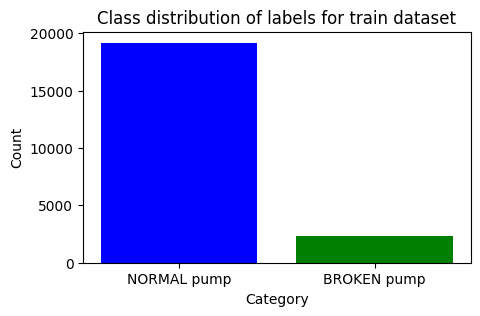

Class TRUE (broken pump) makes 10.947955390334572% of the data, class FALSE (normal pump) makes 89.05204460966543%


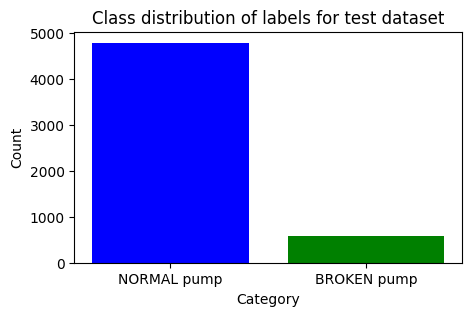

In [179]:
# I decided to visaully inspect the class distribution after applying K-fold cross-validation splits (sanity check).

def plot_binary_labels_distribution(label_names: list, y: np.ndarray, title: str) -> None:
    count_true = np.count_nonzero(y)
    count_false =  len(y) - count_true
    classes = [count_false, count_true]
    print(f"Class TRUE (broken pump) makes {count_true/len(y)*100}% of the data, class FALSE (normal pump) makes {count_false/len(y)*100}%")
    plt.figure(figsize=(5, 3))  
    plt.bar(label_names, classes, color=['blue', 'green']) 
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(label_names)
    plt.show()

label_names = ['NORMAL pump', 'BROKEN pump']
plot_binary_labels_distribution(label_names, y_train, 'Class distribution of labels for train dataset')
plot_binary_labels_distribution(label_names, y_test , 'Class distribution of labels for test dataset')

In [174]:
# Since dataset is highly imbalanced, I decided to try model that is more robust to imbalanced datasets: Random Forest.
# The Seach grid parameters were taken from: https://medium.com/@suniaidvpr/predictive-maintenance-of-pumps-7c358f0efe68.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
# random forest model
r_forest_model = RandomForestClassifier(criterion='gini', 
                                      random_state=21, 
                                      n_jobs=-1)

param_grid = {'n_estimators': [10, 25, 50, 100,150, 200],
                'max_depth': [1, 3, 5, 10, 20, 30, 50]}

# defining model to tune hyperparameter
r_forest_cv = GridSearchCV(estimator=r_forest_model,
                        param_grid=param_grid,
                        cv=3,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

r_forest_cv.fit(X_train, y_train)
best_model = r_forest_cv.best_estimator_  
y_pred_rf = best_model.predict(X_test)

print("Best Parameters:", r_forest_cv.best_params_)  
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# The results slightly changed, but are still unsufficient. Predictiion of positive class (failed pump) shows that only 11% of instances predicted as class 1 are actually class 1.
# 1% of actual class 1 instances were predicted as class 1, so we need futher improvements. When it comes to the negative class (normal pump),
# 89% of cases predicted as class 0 are actually class 0, while 99% of actual class 0 instances were predicted as class 0.

285883.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
285883.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi

Best Parameters: {'max_depth': 30, 'n_estimators': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      4791
           1       0.11      0.01      0.02       589

    accuracy                           0.88      5380
   macro avg       0.50      0.50      0.48      5380
weighted avg       0.80      0.88      0.84      5380

Accuracy: 0.8795539033457249
Confusion Matrix:
 [[4724   67]
 [ 581    8]]


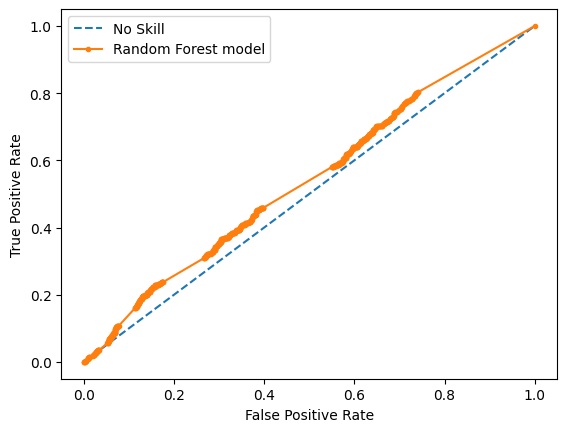

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# In this part, I tried to find the optimal threshold value instead of using the default 0.5, since the dataset is highly imbalanced.
# First of all, I looked at the ROC curve of the existing model.

y_pred_rf = best_model.predict_proba(X_test)
rf_probs = y_pred_rf[:, 1]
# calculate scores
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest model')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# The ROC curve plotted indicates that the model's ability to distinguish between the positive and negative classes is 
# not much better than random guessing. It looks almost as the "No skill" diagonal curve.

In [176]:
# Since the treshold of 0.5 definitely does not work properly, I computed the optimal treshold value by computing the  
# Geometric Mean (G-Mean). This is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
# Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

gmeans = np.sqrt(tpr * (1 - fpr))  
ix = np.argmax(gmeans) 
optimal_threshold_rf = thresholds[ix]
print(f'Optimal Threshold: {optimal_threshold_rf}')

probabilities_rf = best_model.predict_proba(X_test)[:, 1]  
predictions_custom_threshold = (probabilities_rf >= optimal_threshold_rf).astype(int)

Optimal Threshold: 0.10461469534050179


In [177]:
from sklearn.metrics import classification_report, confusion_matrix

# evaluate the predictions for manually changed treshold 
print(classification_report(y_test, predictions_custom_threshold))
print(confusion_matrix(y_test, predictions_custom_threshold))

# This model performance is better than the Random Forest model used with deafult 0.5 prediction threshold, altough it still needs further improvements.
# When it comes to the negative class, 90% of cases predicted as class 0 are actually class 0, while 62% of actual class 0 cases were predicted as class 0. Recall of the 
# negative class decreased significantly. Only 13% of cases predicted as class 1 are actually class 1,
# while 45% of actual class 1 instances were predicted as class 1, which is an improvement over the previous model. F1 score improved for the
# negative class compared to the previous model, which caused the decrease of the overall accuracy (increase in the number of false positives).
# The trade-off increased model's abbility to detect positive class (broken pump), but at the cost of increasing false positives.


              precision    recall  f1-score   support

           0       0.90      0.62      0.73      4791
           1       0.13      0.45      0.20       589

    accuracy                           0.60      5380
   macro avg       0.51      0.53      0.46      5380
weighted avg       0.82      0.60      0.67      5380

[[2954 1837]
 [ 323  266]]


Class TRUE (broken pump) makes 50.0% of the data, class FALSE (normal pump) makes 50.0%


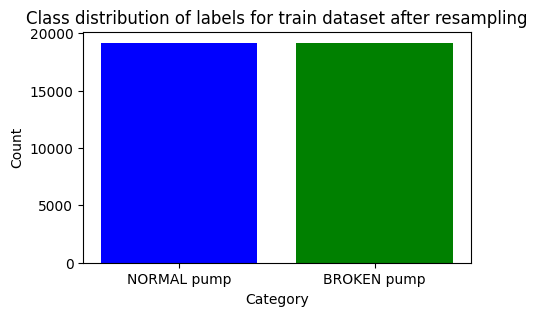

In [180]:

# In an attempt to solve the poor model performance due to  an imbalanced dataset, 
# I explored the use of resampling techniques, specifically oversampling. 
# Generally speaking, this methods  carry potential risks such as overfitting, as the model is exposed to replicated instances of the minority class. 
# This could potentially skew the model's predictive accuracy on unseen data, and it may not reflect real-world data distributions. 
# I implemented oversampling to evaluate its impact on model performance. However, the results did not show significant improvement.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
# resampling 
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# plot resampled labels distribution, sanity check
plot_binary_labels_distribution(label_names, y_train_resampled, 'Class distribution of labels for train dataset after resampling')

In [162]:
# random forest model, resampled data
r_forest_cv.fit(X_train_resampled, y_train_resampled)
best_model = r_forest_cv.best_estimator_  
y_pred_rf2 = best_model.predict(X_test)

print("Best Parameters:", r_forest_cv.best_params_)  
print("Classification Report:\n", classification_report(y_test, y_pred_rf2))
print("Accuracy:", accuracy_score(y_test, y_pred_rf2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf2))

284729.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
284729.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi

Best Parameters: {'max_depth': 50, 'n_estimators': 150}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      4791
           1       0.15      0.27      0.19       589

    accuracy                           0.75      5380
   macro avg       0.53      0.54      0.52      5380
weighted avg       0.82      0.75      0.78      5380

Accuracy: 0.754089219330855
Confusion Matrix:
 [[3897  894]
 [ 429  160]]


In [ ]:
# The results are better in comparison with the Random Forest model with default threshold value, and are similar to the results 
# with the manual thresholding technique. However, manual thresholding still gave me better results in positive class prediction.
# Overally, I think that the model needs improvements. Further step that I would take is considering the features once again. I would double check if the chosen
# features are indeed "catching" the differences between the classes, or if there are some additional features that could have been added to the model.
# Since the working time on the task is limited, I decided to leave the results as they are. 